<a href="https://colab.research.google.com/github/wu162/Tipdm-2019B/blob/master/Tipdm_2019B_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 10.2 GB  | Proc size: 4.4 GB
GPU RAM Free: 468MB | Used: 14611MB | Util  97% | Total 15079MB


In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# 指定当前的工作文件夹
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Tipdm-2019B/") 

In [4]:
!ls

ct_scan  test_img	      Tipdm_2019B_2.ipynb  unet_Noaug_256_1.h5
drive	 test_mask	      unet_256_1.hdf5	   unet_Noaug_256_2.h5
mask	 Tipdm_2019B_1.ipynb  unet_membrane.hdf5   unet_Noaug_3.hdf5


In [0]:
#start from here
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
#from keras import backend as K
import tensorflow as tf

np.random.seed(2019)
tf.set_random_seed(2019)

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection+smooth) / (K.sum(y_true_f) + K.sum(y_pred_f)+smooth)


def bce_dice_loss(y_true, y_pred):
    return  binary_crossentropy(y_true, y_pred) + 1 - dice_coef(y_true, y_pred)
    #return  1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_coef_loss(y_true, y_pred):
    return 0.5*binary_crossentropy(y_true, y_pred)+1-iou_coef(y_true, y_pred)

def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(Adam(lr = 1e-5),binary_crossentropy, metrics = ['accuracy',dice_coef])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

      
    return model

In [0]:
import scipy.misc

img2=scipy.misc.imread('./ct_scan/train_img/1001_10001.png',mode='I')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
X_path='./ct_scan/train_img/'
y_path='./mask/train_mask/'
x_files_names=os.listdir(X_path)
y_files_names=os.listdir(y_path)
x_files=np.array([X_path+file for file in x_files_names])
y_files=np.array([y_path+file for file in y_files_names])

In [0]:
import random
index=list(range(len(x_files)))
test_index=random.sample(index, 500)
train_index=list(set(index) - set(test_index))
x_files_train=x_files[train_index].tolist()
y_files_train=y_files[train_index].tolist()
x_files_test=x_files[test_index].tolist()
y_files_test=y_files[test_index].tolist()

In [20]:
len(y_files_test)

500

In [0]:
import matplotlib.pyplot as plt
import scipy.misc
%matplotlib inline

def get_train_batch(X_path, y_path, batch_size):
    while 1:
        for i in range(0, len(X_path), batch_size):
            x = np.array([scipy.misc.imread(path,mode='I') for path in X_path[i:i+batch_size]])
            y = np.array([plt.imread(path) for path in y_path[i:i+batch_size]])
            y=y==1
            x=x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
            y=y.reshape(y.shape[0],y.shape[1],y.shape[2],1)
            yield x,y

In [0]:
batch_size=8
model_checkpoint=ModelCheckpoint('unet_Noaug_4.hdf5', monitor='loss',verbose=1, save_best_only=True)
model=unet(input_size = (256,256,1))
model.load_weights('unet_Noaug_3.hdf5')
model.fit_generator(get_train_batch(x_files_train,y_files_train,batch_size),steps_per_epoch=2529/batch_size,epochs=300,validation_data=get_train_batch(x_files_test,y_files_test,batch_size),validation_steps=500/batch_size,callbacks=[model_checkpoint])

Epoch 1/300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


317/316 [==============================] - 2884s 9s/step - loss: 9.6537 - acc: 0.3749 - dice_coef: 0.0125 - val_loss: 4.0590 - val_acc: 0.7390 - val_dice_coef: 0.0126

Epoch 00001: loss improved from inf to 9.66785, saving model to unet_Noaug_3.hdf5
Epoch 2/300
317/316 [==============================] - 35s 111ms/step - loss: 2.8244 - acc: 0.8143 - dice_coef: 0.0097 - val_loss: 0.1465 - val_acc: 0.9900 - val_dice_coef: 2.2295e-04

Epoch 00002: loss improved from 9.66785 to 2.83068, saving model to unet_Noaug_3.hdf5
Epoch 3/300
317/316 [==============================] - 34s 107ms/step - loss: 0.1799 - acc: 0.9865 - dice_coef: 0.0021 - val_loss: 0.1297 - val_acc: 0.9911 - val_dice_coef: 2.5754e-04

Epoch 00003: loss improved from 2.83068 to 0.17917, saving model to unet_Noaug_3.hdf5
Epoch 4/300
317/316 [==============================] - 33s 105ms/step - loss: 0.1433 - acc: 0.9898 - dice_coef: 0.0012 - val_loss: 0.1237 - val_acc: 0.9920 - val_dice_coef: 3.2200e-04

Epoch 00004: loss impro

In [0]:
path='./ct_scan/train_img/'
files=os.listdir(path)
files=files[0:200]
img=[scipy.misc.imread(path+file,mode='I') for file in files]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [0]:
path='./mask/train_mask/'
files=os.listdir(path)
files=files[0:200]
mask=[plt.imread(path+file) for file in files]

In [0]:
img=np.array(img)
mask=np.array(mask)
mask=mask==1
img2=img.reshape(img.shape[0],img.shape[1],img.shape[2],1)
mask2=mask.reshape(mask.shape[0],mask.shape[1],mask.shape[2],1)

In [0]:
model.evaluate(img2,mask2,verbose=1)

200/200 [==============================] - 4s 20ms/step


[0.1002488390868325, 0.9937803649902344, 0.04008594109676778]

In [0]:
preds=model.predict(img2)

In [0]:
np.max(preds)

0.013926059

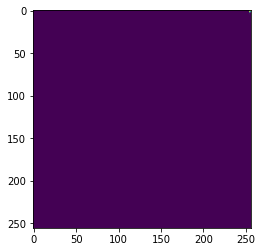

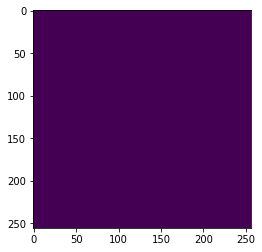

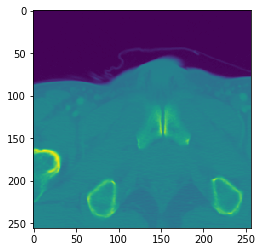

In [0]:
ix=11
plt.imshow(np.squeeze(preds[ix]))
plt.show()
plt.imshow(mask[ix])
plt.show()
plt.imshow(img[ix])
plt.show()

In [0]:
x_folder='./ct_scan/train_img/'
y_folder='./mask/train_mask/'
x_files=os.listdir(x_folder)
y_files=os.listdir(y_folder)
x_files.sort()
y_files.sort()
x_files=x_files[0:200]
y_files=y_files[0:200]
for i in range(len(x_files)):
  x=scipy.misc.imread(x_folder+x_files[i],mode='I')
  y=plt.imread(y_folder+y_files[i])
  x=x.reshape(1,x.shape[0],x.shape[1],1)
  y=y.reshape(1,y.shape[0],y.shape[1],1)
  score=model.evaluate(x,y,verbose=0)
  print(score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[0.39252448081970215, 0.97564697265625, 0.0006261740927584469]
[0.5501736402511597, 0.9658660888671875, 0.0004468275292310864]
[0.45966681838035583, 0.9714813232421875, 0.0005347593687474728]
[0.28234219551086426, 0.98248291015625, 0.0008703219937160611]
[0.2233159840106964, 0.98614501953125, 0.001100110006518662]
[0.23561310768127441, 0.985382080078125, 0.0010427528759464622]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 1.0, 1.0]
[1.0000001537946446e-07, 

KeyboardInterrupt: ignored